In [1]:
%reload_ext autoreload
%autoreload 2
import os
import sys
import json
from collections import defaultdict
from matplotlib import pyplot as plt
import cv2
import numpy as np
import pandas as pd
from skimage import io
from PIL import Image
from tqdm import tqdm
Image.MAX_IMAGE_PIXELS = None

In [2]:
HOME = os.path.expanduser("~")
PATH = os.path.join(HOME, 'programming/pipeline_utility/src')
sys.path.append(PATH)

In [3]:
from pipeline.utilities.utilities_alignment import (create_warp_transforms, parse_elastix)
def transform_create_alignment(points, transform):
    a = np.hstack((points, np.ones((points.shape[0], 1))))
    b = transform.T[:, 0:2]
    c = np.matmul(a, b)
    return c

In [4]:
animal = 'DK55'
downsample_factor = 32
section_test_num = 228
filename = f'{str(section_test_num).zfill(3)}.tif'
CSV_PATH = f'/net/birdstore/Active_Atlas_Data/data_root/atlas_data/{animal}'

In [5]:
IMG_PATH = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps'
cshl_csvfile = 'cshl.premotor.csv'
cshl_csvpath = os.path.join(CSV_PATH, cshl_csvfile)
cshl_df = pd.read_csv(cshl_csvpath, names=['section','x','y'])

In [6]:
cshl_df.head()

,section,x,y
0,221,22359,21440
1,221,22359,21456
2,221,21751,21184
3,221,22039,21184
4,221,21815,21024


In [7]:
sections = cshl_df['section'].unique().tolist()
print(sections)

[221, 222, 223, 224, 225, 226, 227, 228, 229, 230]


In [8]:
section_size = {}
for section_num in sections:
    filename = str(section_num).zfill(3) + '.tif'
    filepath = os.path.join(IMG_PATH, 'CH3/full', filename)
    input_image = Image.open(filepath)
    rotated_height = input_image.width
    section_size[section_num] = rotated_height
    input_image.close()

In [9]:
for index, row in cshl_df.iterrows():
    section_num = int(row['section'])
    rotated_height = section_size[section_num]
    cshl_df.at[index,'xp'] = cshl_df.at[index,'y'] 
    cshl_df.at[index,'yp'] = rotated_height - cshl_df.at[index,'x'] 

## Test on unaligned, normalized and rotated image

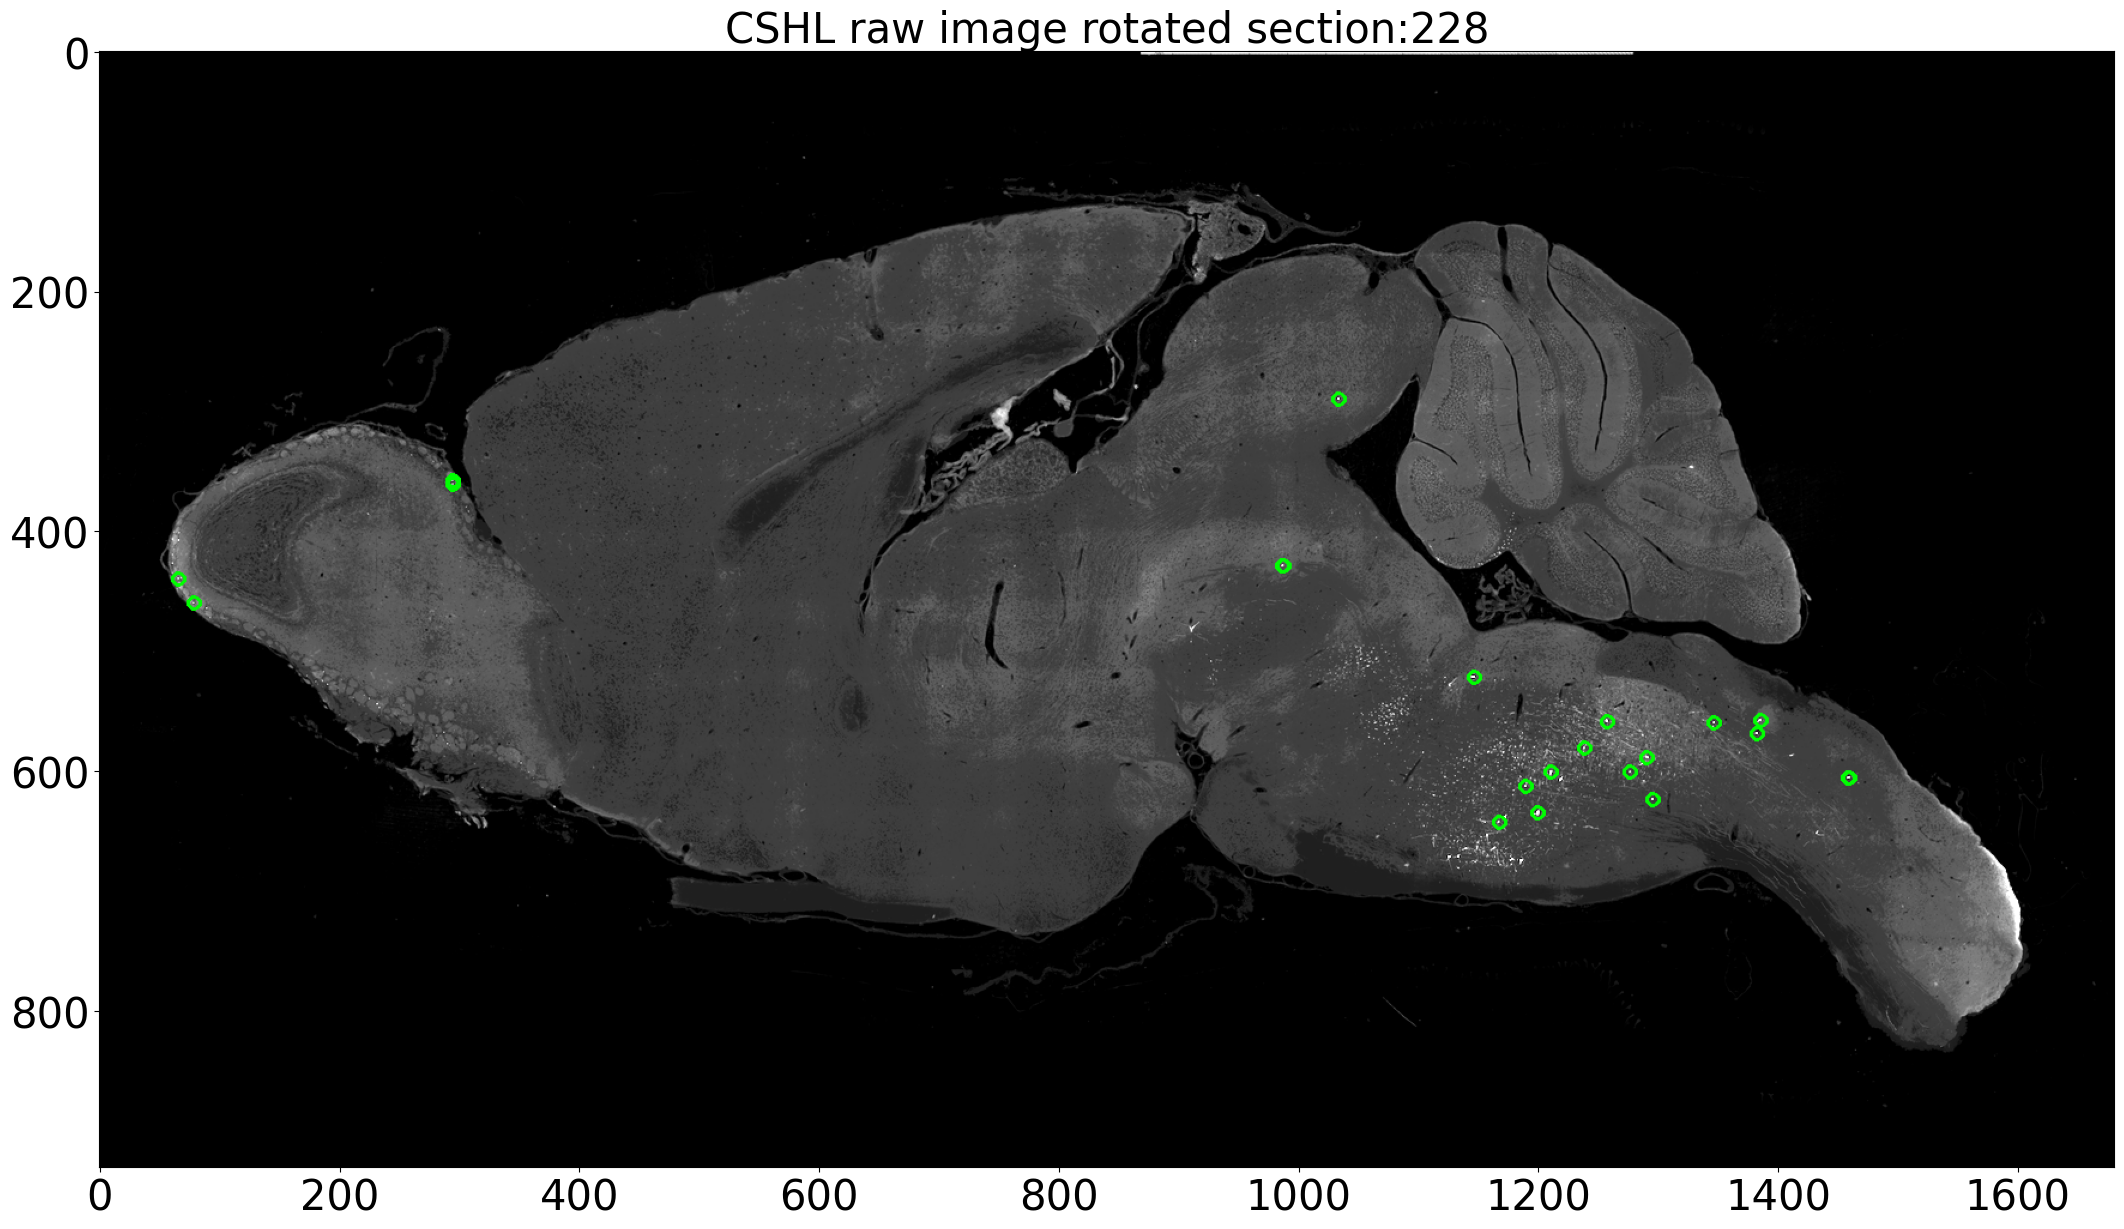

In [10]:
filename = f'{str(section_test_num).zfill(3)}.tif'
filepath = os.path.join(IMG_PATH, 'CH3/normalized', filename)
img = cv2.imread(filepath, -1)
img = (img/256).astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
radius = 5
color = (0,255,1)
df = cshl_df.loc[cshl_df['section'] == section_test_num]
for index, row in df.iterrows():
    x = round(row['xp']/downsample_factor) 
    y = round(row['yp']/downsample_factor)
    cv2.circle(img, (int(x), int(y)), radius, color, 2)

outpath = os.path.join(IMG_PATH,'CH3',f'{section_test_num}.out.tif')
cv2.imwrite(outpath, img)
fig=plt.figure(figsize=(26,18), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(img, cmap="gray")
plt.title('CSHL raw image rotated section:{}'.format(section_test_num), fontsize=30)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)
plt.show()

## Get the annotation points

In [11]:
section_vertices = defaultdict(list)
for index, row in cshl_df.iterrows():
    section_num = int(row['section'])
    x = row['xp']
    y = row['yp']
    section_vertices[section_num].append([x,y])

## Reproduce padded image transform

In [12]:
# find the difference between the image stack size which is consistent for all images
# and the individual shape of the aligned image: use thumbnail 
INPUT = os.path.join(IMG_PATH, 'CH3/thumbnail')
# width and height are from the thumbnail_aligned images
fixed_width = 1875
fixed_height = 1062
#1875x1062
cleaned_section_points = defaultdict(list)

for section_num in sections:
    filename = str(section_num).zfill(3) + '.tif'
    filepath = os.path.join(INPUT, filename)    
    input_image = Image.open(filepath)
    xshift = (fixed_width - input_image.height) / 2 
    yshift = (fixed_height - input_image.width) / 2
    vertices = section_vertices[section_num]
    points = np.array(vertices) / downsample_factor
    shifts = np.array([xshift, yshift])
    cleaned_section_points[section_num] = points + shifts


## Test with padded image

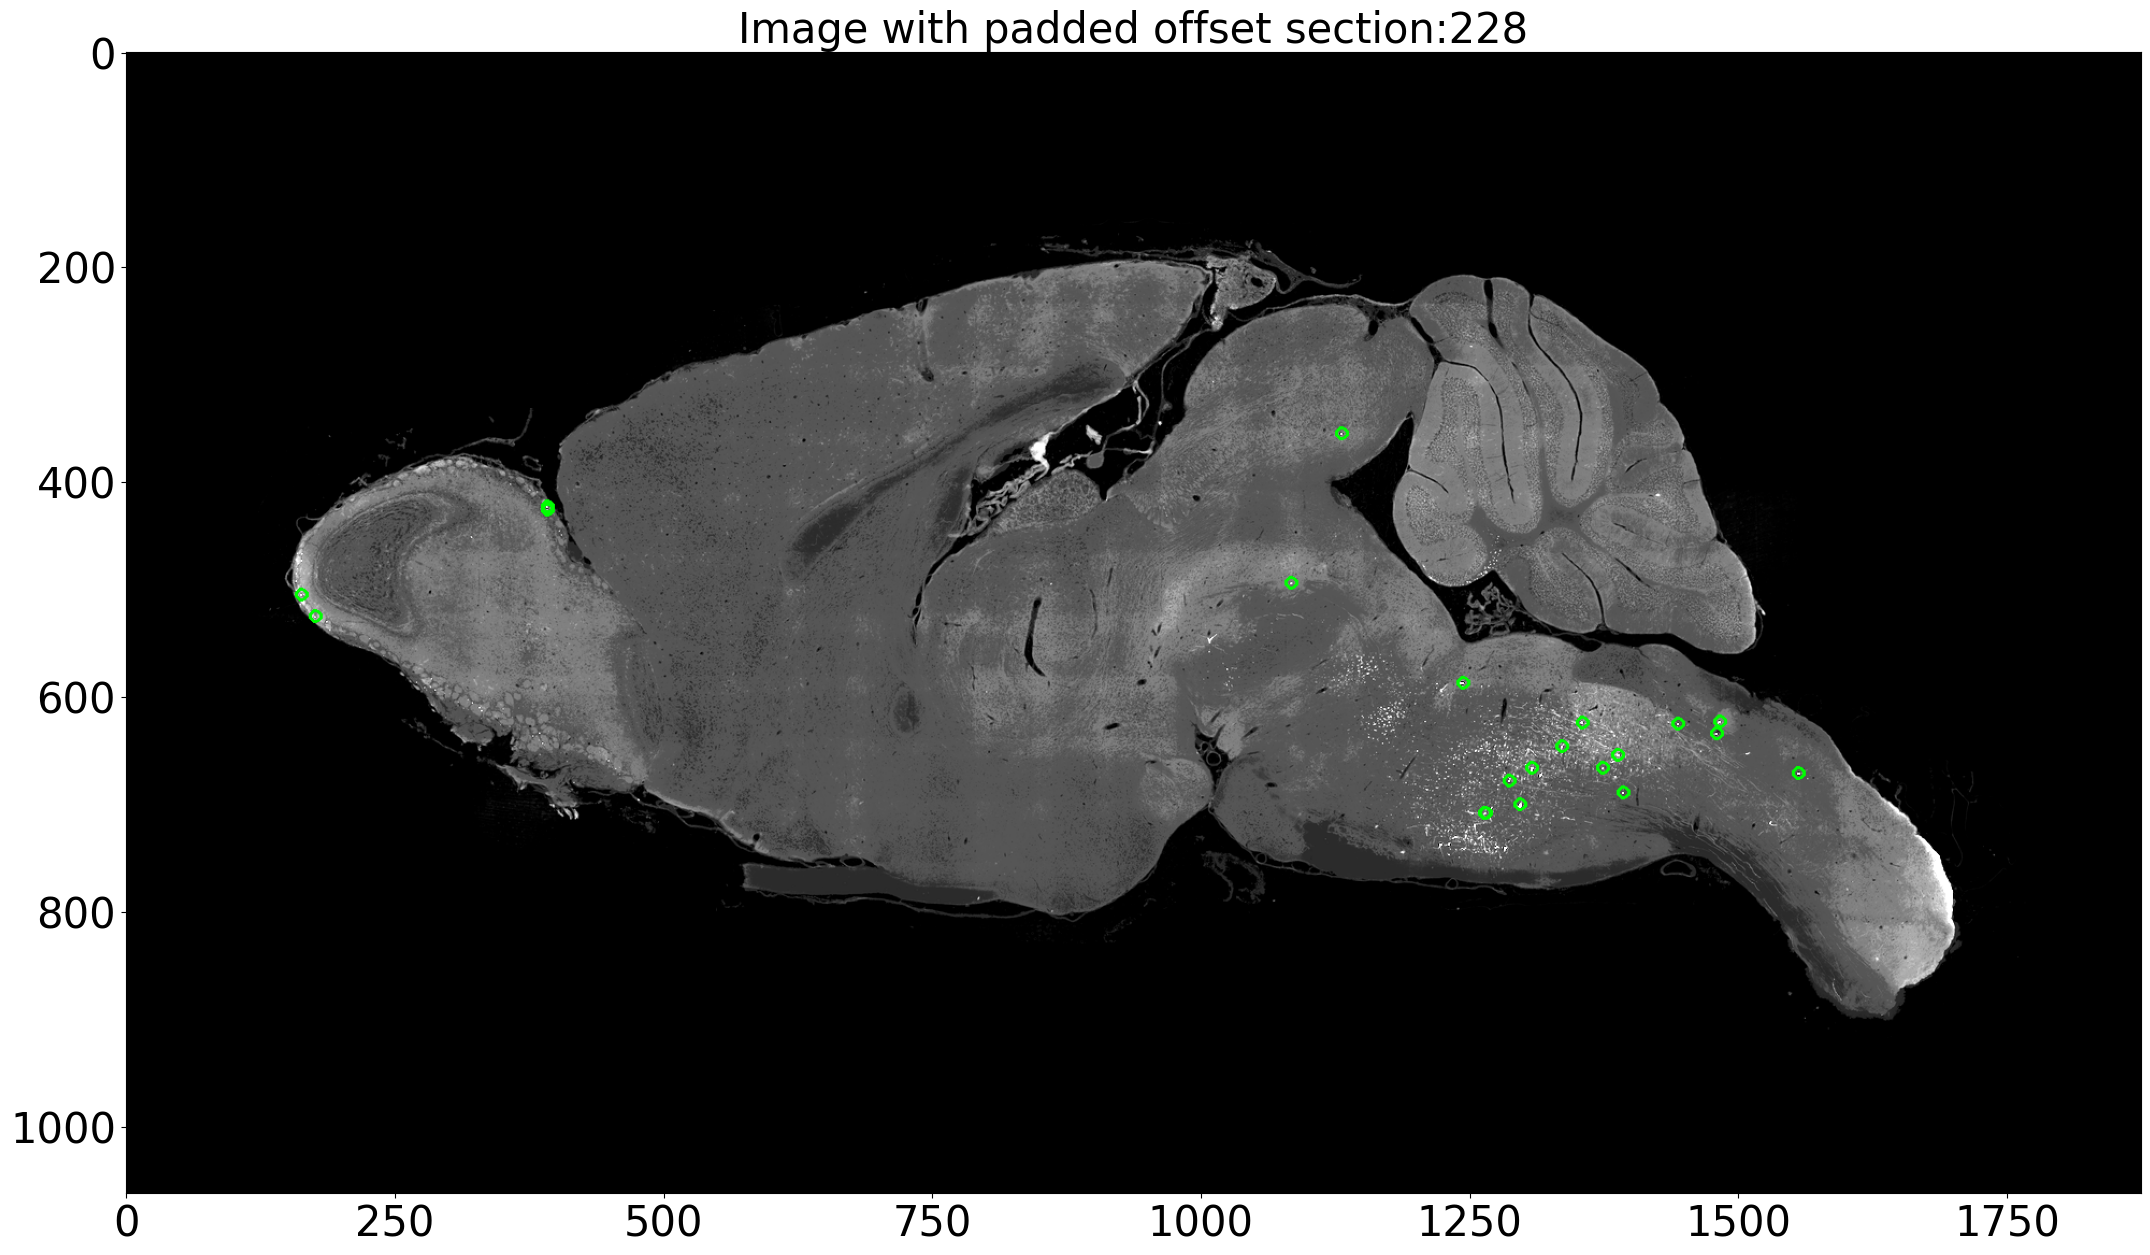

In [13]:
# test on image that has been rotated and placed in standard size
filename = f'{str(section_test_num).zfill(3)}.tif'
filepath = os.path.join(IMG_PATH, 'CH3/thumbnail_cleaned_normalized', filename)
img = cv2.imread(filepath, -1)
img = (img/256).astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

points = cleaned_section_points[section_test_num]
for point in points:
    x = point[0]
    y = point[1]
    cv2.circle(img, (int(x), int(y)), radius, color, 2)
outpath = os.path.join(IMG_PATH,'CH3',f'{section_test_num}.cleaned.out.tif')
cv2.imwrite(outpath, img)
fig=plt.figure(figsize=(26,18), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(img, cmap="gray")
plt.title('Image with padded offset section:{}'.format(section_test_num), fontsize=30)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)
plt.show()

## Reproduce alignment transform

In [18]:
transforms = parse_elastix(animal)
warp_transforms = create_warp_transforms(animal, transforms, downsample=True)
ordered_transforms = sorted(warp_transforms.items())

section_transform = {}
for filename, transform in ordered_transforms:
    section_num = int(filename.split('.')[0])
    transform = np.linalg.inv(transform) 
    section_transform[section_num] = transform
    
aligned_section_points = defaultdict(list)
for section_num, vertices in cleaned_section_points.items():
    print(vertices.shape)
    points = transform_create_alignment(vertices, section_transform[section_num]) # create_alignment transform
    aligned_section_points[section_num] = points    

(102, 2)
(53, 2)
(49, 2)
(26, 2)
(21, 2)
(31, 2)
(17, 2)
(23, 2)
(54, 2)
(44, 2)


In [15]:
data = []
resolution = 0.325
for section_num,v in aligned_section_points.items():
    #print(section_num, len(v))
    for x,y in v:
        data.append([x*downsample_factor,y*downsample_factor,section_num])    

df = pd.DataFrame(data, columns=['x','y','section'])
df = df.astype({'section':'int32','x': 'float64', 'y':'float64'})
outfile = f'/net/birdstore/Active_Atlas_Data/data_root/atlas_data/DK55/cshl2dk.aligned.csv'
df.to_csv(outfile, index=False, header=False)

## Test transformation on aligned image

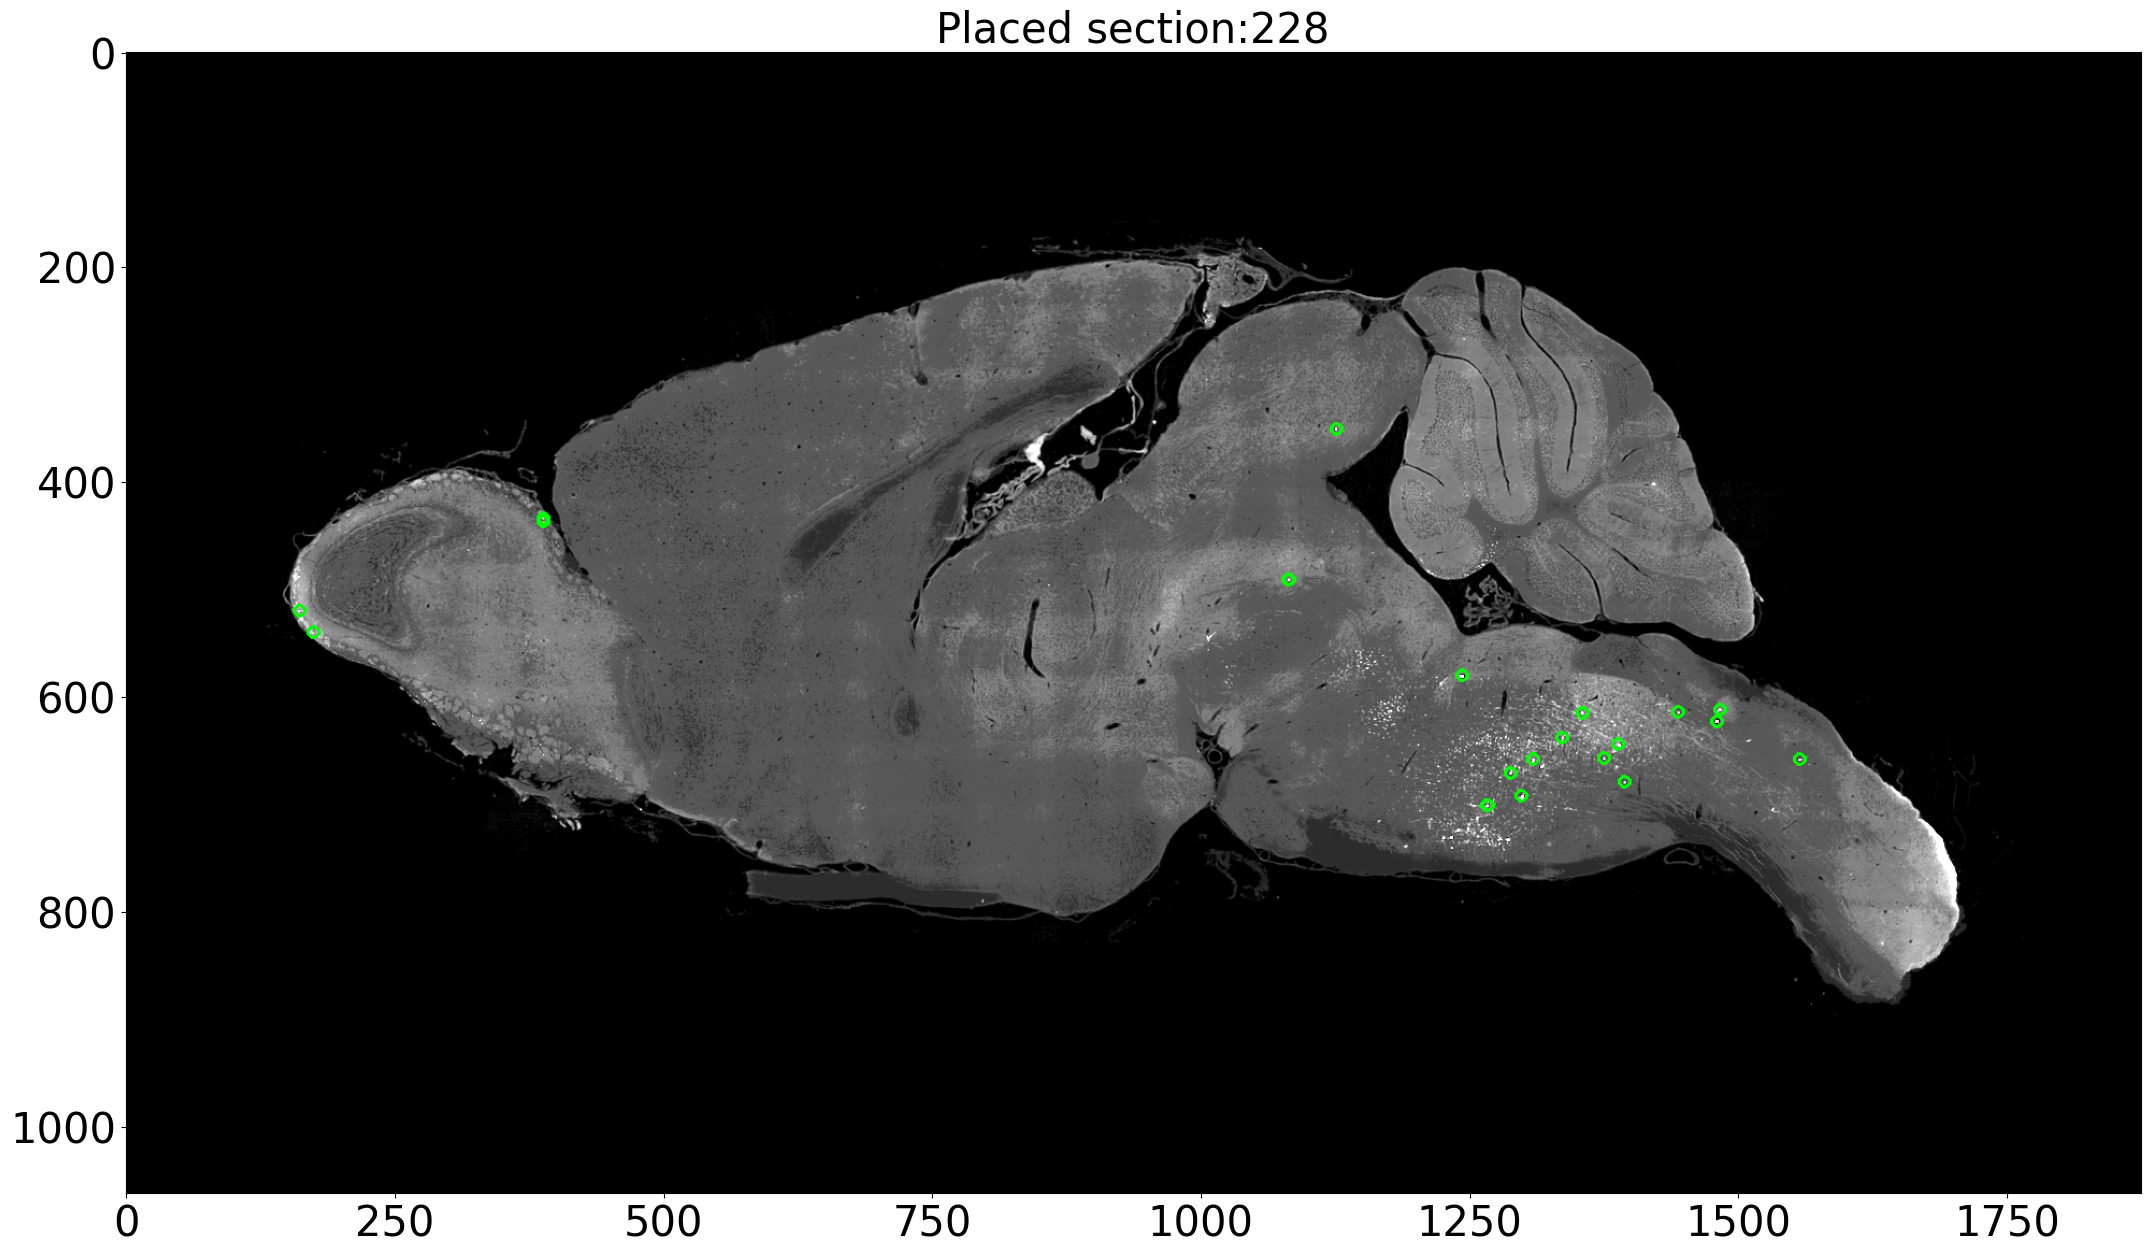

In [16]:
filename = f'{str(section_test_num).zfill(3)}.tif'
filepath = os.path.join(IMG_PATH, 'CH3/thumbnail_aligned_normalized', filename)
img = cv2.imread(filepath, -1)
img = (img/256).astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

points = aligned_section_points[section_test_num]
for point in points:
    x = point[0]
    y = point[1]
    cv2.circle(img, (int(x), int(y)), radius, color, 2)
outpath = os.path.join(IMG_PATH,'CH3',f'{section_test_num}.aligned.out.tif')
cv2.imwrite(outpath, img)
fig=plt.figure(figsize=(26,18), dpi= 100, facecolor='w', edgecolor='k')
plt.imshow(img, cmap="gray")
plt.title('Placed section:{}'.format(section_test_num), fontsize=30)
plt.tick_params(axis='x', labelsize=30)
plt.tick_params(axis='y', labelsize=30)
plt.show()